In [68]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import numpy as np
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
import PIL
import matplotlib.pyplot as plt

In [53]:
root_dir = '/Users/edwardl/Downloads/data 2'

In [54]:
os.path.exists(root_dir)

True

In [55]:
# visualize npy file
test_file = os.path.join(root_dir, 'sample_45', 'label_44.npy')
print(os.path.exists(test_file))
file = np.load(test_file)
print(file.shape)
print(file.max(), file.min())

True
(384, 512)
31 0


In [56]:
items = []
for root, dnames, fnames in sorted(os.walk(root_dir, followlinks=False)):
    tmp = {}
    for f in fnames:
        if f.lower().endswith(('png', 'npy')) and (not 'latent' in f):
            pathname, extension = os.path.splitext(f)
            num = pathname.split('_')[-1]
            tmp[num] = tmp.get(num, []) + [os.path.join(root, f)]
    items += list(map(lambda x : sorted(x), filter(lambda x : len(x) == 2, tmp.values())))
print(items)

TypeError: 'Tensor' object is not callable

In [109]:
class TestDataset(Dataset):
    def __init__(self, dataset_path, img_size, **kwargs):
        super().__init__()

        self.dataset_path = dataset_path

        self.samples = self.make_dataset(dataset_path)
        if len(self.samples) == 0:
            msg = "Found 0 files in subfolders of: {}\n".format(self.dataset_path)
            raise RuntimeError(msg)

        self.image_transform = transforms.Compose(
            [
                transforms.Resize(
                    img_size,
                    interpolation=transforms.InterpolationMode.BILINEAR,
                ),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

        self.map_transform = transforms.Compose(
            [
                transforms.Resize(
                    img_size,
                    interpolation=transforms.InterpolationMode.NEAREST
                ),
                transforms.CenterCrop(img_size)
            ]
        )

        return

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample = self.samples[index]
        X = PIL.Image.open(sample[0])
        X = self.image_transform(X)

        map = np.load(sample[1])
        map = torch.from_numpy(map).unsqueeze(dim=0)
        map = self.map_transform(map)

        return torch.cat((X, map)), 0

    @classmethod
    def make_dataset(cls, directory: str) -> List[Tuple[str, str]]:
        instances = []
        root_dir = os.path.abspath(directory)
        if not os.path.isdir(root_dir):
            raise ValueError("Invalid input directory")
        for root, _, fnames in sorted(os.walk(root_dir, followlinks=False)):
            tmp = {}
            for f in fnames:
                if f.lower().endswith(('png', 'npy')) and (not 'latent' in f):
                    pathname, extension = os.path.splitext(f)
                    num = pathname.split('_')[-1]
                    tmp[num] = tmp.get(num, []) + [os.path.join(root, f)]
            instances += list(map(lambda x : sorted(x), filter(lambda x : len(x) == 2, tmp.values())))
        return instances

In [88]:
del map

NameError: name 'map' is not defined

In [89]:
def colorize_mask(mask, palette):
    # mask: numpy array of the mask

    new_mask = PIL.Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return np.array(new_mask.convert('RGB'))

car_32_palette =[ 255,  255,  255,
                  238,  229,  102,
                  0, 0, 0,
                  124,  99 , 34,
                  193 , 127,  15,
                  106,  177,  21,
                  248  ,213 , 42,
                  252 , 155,  83,
                  220  ,147 , 77,
                  99 , 83  , 3,
                  116 , 116 , 138,
                  63  ,182 , 24,
                  200  ,226 , 37,
                  225 , 184 , 161,
                  233 ,  5  ,219,
                  142 , 172  ,248,
                  153 , 112 , 146,
                  38  ,112 , 254,
                  229 , 30  ,141,
                  115  ,208 , 131,
                  52 , 83  ,84,
                  229 , 63 , 110,
                  194 , 87 , 125,
                  225,  96  ,18,
                  73  ,139,  226,
                  172 , 143 , 16,
                  169 , 101 , 111,
                  31 , 102 , 211,
                  104 , 131 , 101,
                  70  ,168  ,156,
                  183 , 242 , 209,
                  72  ,184 , 226]

Batch of images has shape:  torch.Size([1, 4, 384, 384])
torch.Size([4, 384, 384]) torch.Size([3, 384, 384]) torch.Size([384, 384]) (384, 384, 3)
tensor(31.)
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


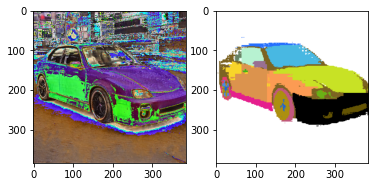

In [111]:
bs = 1

dataset = TestDataset(root_dir, 384)
data_loader = DataLoader(dataset, batch_size=bs, shuffle=False)
for imgs, labels in data_loader:
    print("Batch of images has shape: ",imgs.shape)
    for idx in range(bs):
        sample = imgs[idx, :].squeeze()
        sample_img = sample[0:3, :]
        sample_map = sample[-1, :]
        sample_map_colored = colorize_mask(sample_map.numpy(), car_32_palette)
        print(sample.shape, sample_img.shape, sample_map.shape, sample_map_colored.shape)
        print(sample_map.max())
        print(sample_map[20:25, 20:25])
        print(sample_map_colored[20:25, 20:25, :])
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(transforms.ToPILImage()(sample_img))
        axarr[1].imshow(PIL.Image.fromarray(sample_map_colored))
    break

Batch of images has shape:  torch.Size([1, 4, 64, 64])
torch.Size([4, 64, 64]) torch.Size([3, 64, 64]) torch.Size([64, 64]) (64, 64, 3)
tensor(31.)
tensor([[30.,  3.,  3., 31., 31.],
        [30.,  3.,  3.,  3., 31.],
        [16., 16.,  3.,  3., 31.],
        [16., 16.,  3.,  3.,  3.],
        [ 3., 16.,  3.,  3.,  3.]])
[[[183 242 209]
  [124  99  34]
  [124  99  34]
  [ 72 184 226]
  [ 72 184 226]]

 [[183 242 209]
  [124  99  34]
  [124  99  34]
  [124  99  34]
  [ 72 184 226]]

 [[153 112 146]
  [153 112 146]
  [124  99  34]
  [124  99  34]
  [ 72 184 226]]

 [[153 112 146]
  [153 112 146]
  [124  99  34]
  [124  99  34]
  [124  99  34]]

 [[124  99  34]
  [153 112 146]
  [124  99  34]
  [124  99  34]
  [124  99  34]]]


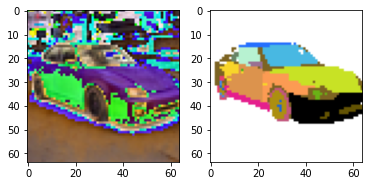

In [112]:
bs = 1

dataset = TestDataset(root_dir, 64)
data_loader = DataLoader(dataset, batch_size=bs, shuffle=False)
for imgs, labels in data_loader:
    print("Batch of images has shape: ",imgs.shape)
    for idx in range(bs):
        sample = imgs[idx, :].squeeze()
        sample_img = sample[0:3, :]
        sample_map = sample[-1, :]
        sample_map_colored = colorize_mask(sample_map.numpy(), car_32_palette)
        print(sample.shape, sample_img.shape, sample_map.shape, sample_map_colored.shape)
        print(sample_map.max())
        print(sample_map[20:25, 20:25])
        print(sample_map_colored[20:25, 20:25, :])
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(transforms.ToPILImage()(sample_img))
        axarr[1].imshow(PIL.Image.fromarray(sample_map_colored))
    break